In [6]:
# from google.colab import drive
google_drive_path = "data/"
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError

In [9]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)

set_seeds()

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [24]:
multi_class_model_filename = 'AutoEncoder_Model/multi_autoencoder_model.h5'
multi_class_encoder_filename = 'AutoEncoder_Model/multi_encoder_model.h5'
multi_class_decoder_filename = 'AutoEncoder_Model/multi_decoder_model.h5'

binary_class_model_filename = 'AutoEncoder_Model/bin_autoencoder_model.h5'
binary_class_encoder_filename = 'AutoEncoder_Model/bin_encoder_model.h5'
binary_class_decoder_filename = 'AutoEncoder_Model/bin_decoder_model.h5'

In [26]:
def load_model_autoencoder(model_filename, encoder_filename, decoder_filename):
  model = load_model(google_drive_path + model_filename)
  encoder = load_model(google_drive_path + encoder_filename)
  decoder = load_model(google_drive_path + decoder_filename)
  return model, encoder, decoder

In [28]:
X_train_multi, Y_train_multi = joblib.load(google_drive_path+'preprocessed_multi_class_all_features_data.joblib')
X_test_real, Y_test_real = joblib.load(google_drive_path+'preprocessed_multi_class_all_features_test_data.joblib')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train_multi, Y_train_multi, test_size=0.25, random_state=42)

In [10]:
encoding_dim = 64
input_dim = X_train.shape[1]

encoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(96, activation='relu'),
    Dense(encoding_dim, activation='relu')
])

decoder = Sequential([
    Input(shape=(encoding_dim,)),
    Dense(96, activation='relu'),
    Dense(128, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

autoencoder.fit(X_train, X_train,
                epochs=200,
                batch_size=1024,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping],
                verbose=0)

In [ ]:
autoencoder.save(google_drive_path + multi_class_model_filename)
encoder.save(google_drive_path + multi_class_encoder_filename)
decoder.save(google_drive_path + multi_class_decoder_filename)

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [30]:
# Run this cell if you want to load previously saved model
autoencoder, encoder, decoder = load_model_autoencoder(multi_class_model_filename, multi_class_encoder_filename, multi_class_decoder_filename)

**AutoEncoder + RF on Multi Class**

In [76]:
# Predictions are on 25% test data from KDDTrain+txt
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_encoded, y_train)

X_test_real_encoded = encoder.predict(X_test_real)

y_pred_val = clf.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred_val)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_val))

2953/2953 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
985/985 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.9960

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16775
           1       1.00      1.00      1.00     11484
           2       0.99      0.99      0.99      2947
           3       0.60      0.21      0.32        14
           4       0.96      0.91      0.93       274

    accuracy                           1.00     31494
   macro avg       0.91      0.82      0.85     31494
weighted avg       1.00      1.00      1.00     31494



In [77]:
# Predictions are on test data from KDDTest+.txt
y_pred = clf.predict(X_test_real_encoded)

accuracy = accuracy_score(Y_test_real, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(Y_test_real, y_pred))

Accuracy: 0.7814

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9855
           1       0.96      0.79      0.87      7460
           2       0.89      0.81      0.85      2421
           3       0.80      0.06      0.11        65
           4       0.97      0.06      0.11      2743

    accuracy                           0.78     22544
   macro avg       0.86      0.54      0.55     22544
weighted avg       0.83      0.78      0.74     22544



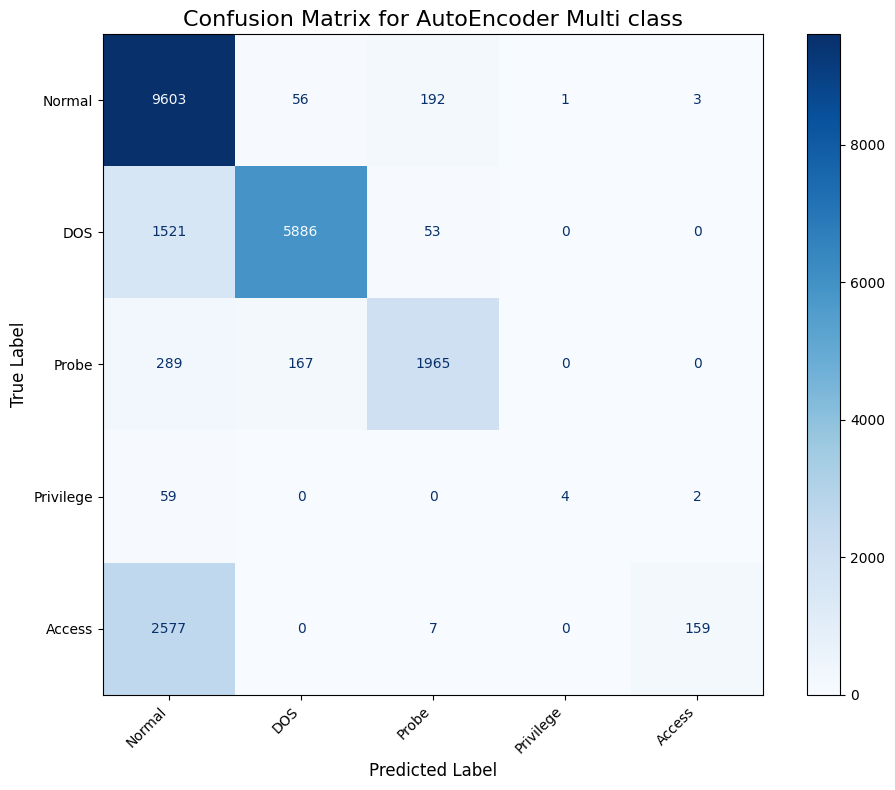

In [78]:
label_map = {0: 'Normal', 1: 'DOS', 2: 'Probe', 3: 'Privilege', 4: 'Access'}

cm = confusion_matrix(Y_test_real, y_pred)

custom_labels = [label_map[i] for i in range(len(label_map))]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax)

plt.title('Confusion Matrix for AutoEncoder Multi class', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

[0 1 2 3 4]


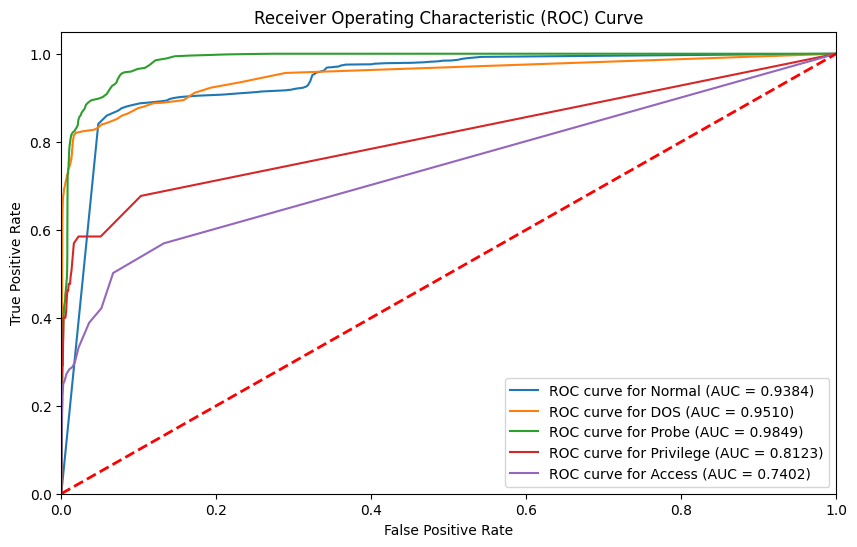

In [10]:
y_test_bin = label_binarize(Y_test_real, classes=clf.classes_)

y_scores = clf.predict_proba(X_test_real_encoded)

unique_labels = np.unique(Y_test_real)
print(unique_labels)

plt.figure(figsize=(10, 6))

label_map = {0: 'Normal', 1: 'DOS', 2: 'Probe', 3: 'Privilege', 4: 'Access'}
for label in unique_labels:
    label_index = np.where(unique_labels == label)[0][0]
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, label_index], y_scores[:, label_index])
    roc_auc = auc(fpr_i, tpr_i)
    plt.plot(fpr_i, tpr_i, label=f'ROC curve for {label_map[label]} (AUC = {roc_auc:.4f})')


plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

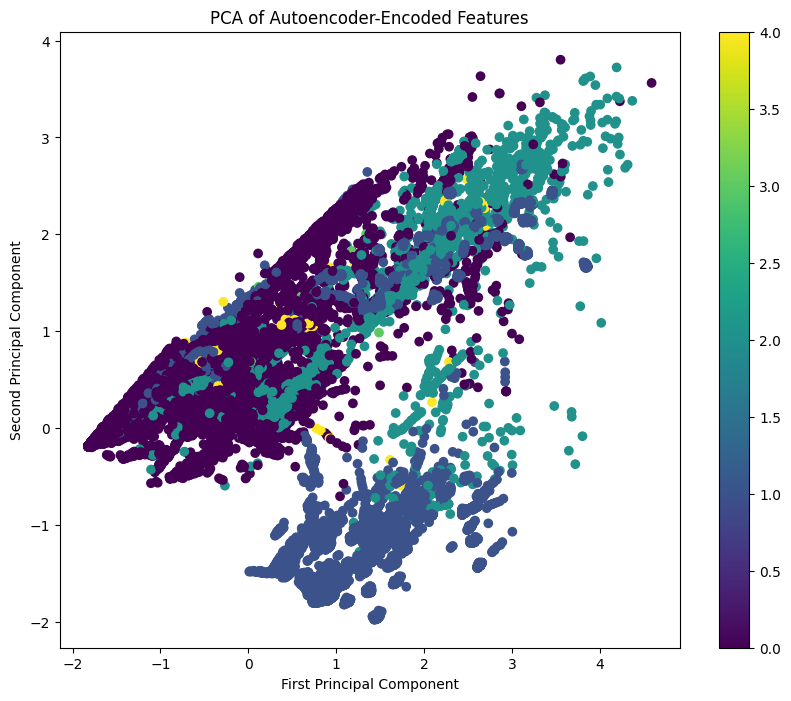

In [11]:
#####PCA
def plot_pca(features, labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

# Plot encoded features
#X_train_encoded = encoder.predict(X_train)
plot_pca(X_train_encoded, y_train, 'PCA of Autoencoder-Encoded Features')


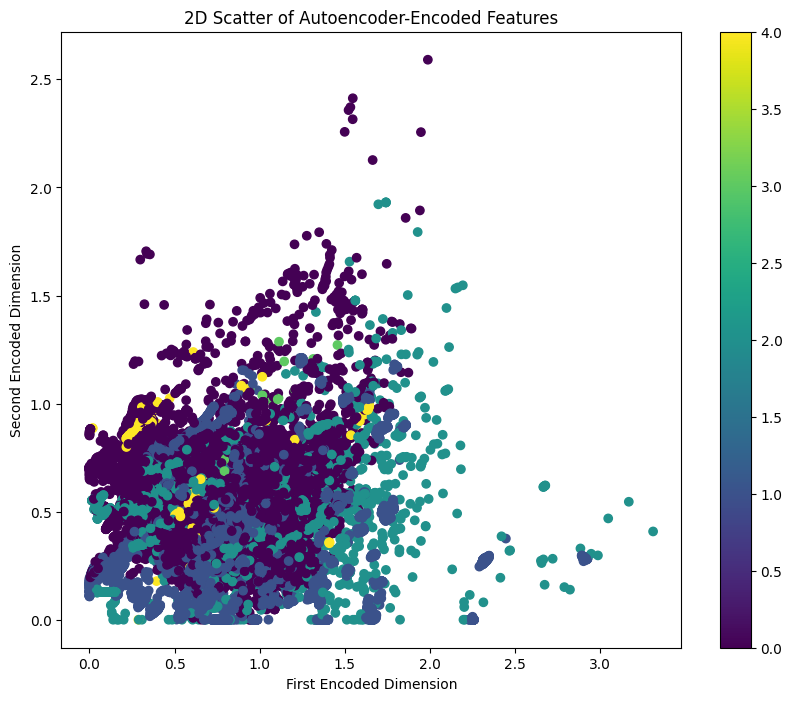

In [12]:
def plot_2d_scatter(features, labels, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('First Encoded Dimension')
    plt.ylabel('Second Encoded Dimension')
    plt.show()

# Only use this if your encoded dimension is 2
#X_train_encoded = encoder.predict(X_train)
plot_2d_scatter(X_train_encoded, y_train, '2D Scatter of Autoencoder-Encoded Features')


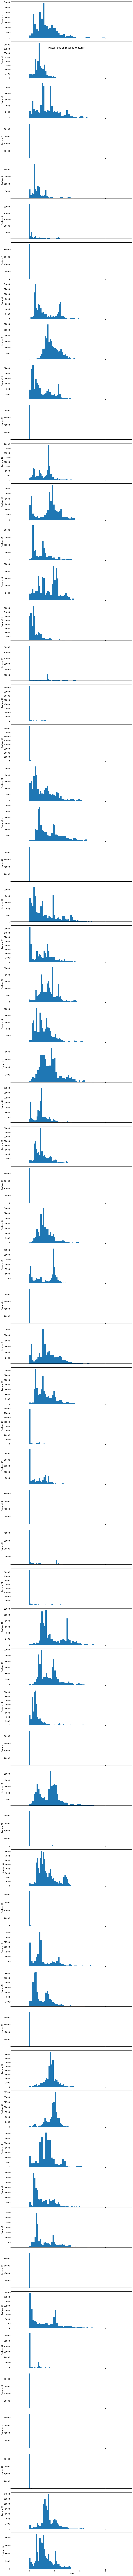

In [13]:
def plot_feature_histograms(features, title):
    n_features = features.shape[1]
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 3*n_features), sharex=True)
    fig.suptitle(title)

    for i in range(n_features):
        axes[i].hist(features[:, i], bins=50)
        axes[i].set_ylabel(f'Feature {i+1}')

    plt.xlabel('Value')
    plt.tight_layout()
    plt.show()

plot_feature_histograms(X_train_encoded, 'Histograms of Encoded Features')


In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='deep')
    plt.title(title)
    plt.show()

plot_tsne(X_train, y_train, 't-SNE of Original Features')

X_train_encoded = encoder.predict(X_train)
plot_tsne(X_train_encoded, y_train, 't-SNE of Autoencoder-Encoded Features')


**AutoEncoder + RF for Binary Classification (Normal/Abnormal)**

In [106]:
X_train_binary, Y_train_binary = joblib.load(google_drive_path+'preprocessed_binary_class_all_features_data.joblib')
X_test_binary_real, Y_test_binary_real = joblib.load(google_drive_path+'preprocessed_binary_class_all_features_test_data.joblib')

In [107]:
X_test_binary_real.shape

(22544, 122)

In [108]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_train_multi, Y_train_multi, test_size=0.25, random_state=42)

In [113]:
encoding_dim = 64
input_dim = X_train_bin.shape[1]

encoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(96, activation='relu'),
    Dense(encoding_dim, activation='relu')
])

decoder = Sequential([
    Input(shape=(encoding_dim,)),
    Dense(96, activation='relu'),
    Dense(128, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [114]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

autoencoder.fit(X_train_bin, X_train_bin,
                epochs=200,
                batch_size=1024,
                validation_data=(X_test_bin, X_test_bin),
                callbacks=[early_stopping],
                verbose=0)

In [22]:
autoencoder.save(google_drive_path + 'bin_autoencoder_model.h5')
encoder.save(google_drive_path + 'bin_encoder_model.h5')
decoder.save(google_drive_path + 'bin_decoder_model.h5')

In [111]:
# Run this cell if you want to load previously saved model
autoencoder, encoder, decoder = load_model_autoencoder(binary_class_model_filename, binary_class_encoder_filename, binary_class_decoder_filename)

In [123]:
# Predictions on 30% test data from KDDTrain+.txt
X_train_encoded = encoder.predict(X_train_bin)
X_test_encoded = encoder.predict(X_test_bin)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_encoded, y_train)

y_pred_val = clf.predict(X_test_encoded)

accuracy = accuracy_score(y_test_bin, y_pred_val)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_val))

2953/2953 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
985/985 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.9957

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16775
           1       1.00      1.00      1.00     11484
           2       0.99      0.99      0.99      2947
           3       0.50      0.21      0.30        14
           4       0.96      0.91      0.93       274

    accuracy                           1.00     31494
   macro avg       0.89      0.82      0.84     31494
weighted avg       1.00      1.00      1.00     31494



In [124]:
# Predictions on test data from KDDTest+.txt
X_test_real_encoded = encoder.predict(X_test_binary_real)

y_pred = clf.predict(X_test_real_encoded)

accuracy = accuracy_score(Y_test_binary_real, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(Y_test_binary_real, y_pred))

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.96      0.79      9711
           1       0.99      0.48      0.65     12833
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.69     22544
   macro avg       0.33      0.29      0.29     22544
weighted avg       0.85      0.69      0.71     22544



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
